In [1]:
import torch
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View
from yolo_wrapper import YOLOv8_COCO_Wrapper
from coco_ds import CocoResults

import logging
logging.disable(logging.INFO)

In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
def compare_ds(trainer, model, dataloaders, labels, preview_idxs:list, view_only=False, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in dataloaders:
        samples.append(torch.stack([ds.dataset[i][1] for i in preview_idxs]))
    View.compare_color(samples, labels, figsize=figsize)
    
    if not view_only:
        for i in range(len(dataloaders)):
            if i in skip_results:
                continue
            result = trainer.test(model, dataloaders[i], verbose=verbose)
            results[labels[i]] = result
        return results
    else:
        return None

In [4]:
PATH_TO_COCO = '/f_storage/datasets/coco/2017'
NUM_IMG_EVAL = 10000
prep = Preprocess(PATH_TO_COCO, (640, 640), dataset_type='coco', shuffle=False, batch_size=32)
preview_idxs = [2, 53, 300, 475]
%matplotlib inline

In [5]:
prep.reset_trans()
coco = prep.get_loader()
model = YOLOv8_COCO_Wrapper(CocoResults(coco.dataset), 'yolov8s.pt')
model = Model_Wrapper(model, model_type='yolo')
trainer = pl.Trainer(accelerator='auto', limit_test_batches=10)

##### Test On Orignal Dataset

2023-04-04 16:28:59.121242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:28:59.256931: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-04 16:28:59.836763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-04 16:28:59.836821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; 

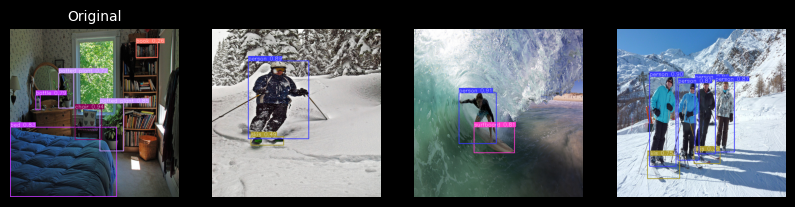

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     61.03763961791992     │
│      Pixel Val MEAN       │    108.80918884277344     │
│       Pixel Val STD       │     71.07572937011719     │
│        mAP 50:95 %        │     43.99159788397346     │
└───────────────────────────┴───────────────────────────┘

In [6]:

samples  = torch.stack([coco.dataset[i][1] for i in preview_idxs])
plots = model.plot(samples)
View.compare_color(plots, 'Original')
orig_results = trainer.test(model, coco)

##### Test on Dark Images

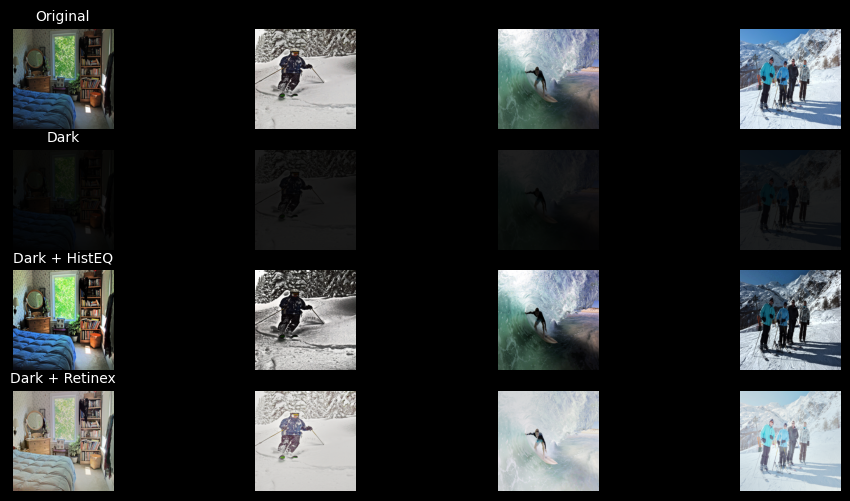

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    59.429100036621094     │
│      Pixel Val MEAN       │     13.60114860534668     │
│       Pixel Val STD       │     8.884466171264648     │
│        mAP 50:95 %        │     34.22554905339609     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     59.82419967651367     │
│      Pixel Val MEAN       │    112.60296630859375     │
│       Pixel Val STD       │     76.30614471435547     │
│        mAP 50:95 %        │     40.24812890827383     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     59.77937698364258     │
│      Pixel Val MEAN       │    164.74588012695312     │
│       Pixel Val STD       │    46.675392150878906     │
│        mAP 50:95 %        │     38.86877068597085     │
└───────────────────────────┴───────────────────────────┘

In [7]:
prep.reset_trans()
coco_dark = prep.luminance(1/8).get_loader()
coco_dark_histeq = prep.copy().hist_eq().get_loader()
coco_dark_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_dark_results = compare_ds(trainer, model, 
                                 [prep.basic_loader(), coco_dark, coco_dark_histeq, coco_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_idxs)

##### Test on Bright Images

In [8]:
prep.reset_trans()
coco_bright = prep.luminance(2).get_loader()
coco_bright_histeq = prep.copy().hist_eq().get_loader()
coco_bright_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_bright_results = compare_ds(trainer, model,
                                 [prep.basic_loader(), coco_bright, coco_bright_histeq, coco_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_idxs)

TypeError: compare_ds() missing 1 required positional argument: 'preview_idxs'

##### Test Histogram Eq on Low Contrast Images

In [ ]:
prep.reset_trans()
coco_low_cont = prep.brightness_contrast(0,0.1).get_loader()
coco_low_cont_histeq = prep.copy().hist_eq().get_loader()
coco_low_cont_retinex = prep.copy().retinex('SSR', 100).get_loader()
coco_low_cont_results = compare_ds(trainer, model,
                                 [prep.basic_loader(), coco_low_cont, coco_low_cont_histeq, coco_low_cont_retinex],
                                 ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
                                 preview_idxs)